<a href="https://colab.research.google.com/github/piremonte/ProyectoML/blob/master/ML_AnalisisSeriesTiempo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## importar librerias 

In [ ]:
import numpy as np
import pandas as pd

# Import a scoring metric to compare methods
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style="ticks")

# Modelo LSTM
import tensorflow as tf
from tensorflow import keras 
from sklearn.preprocessing import MinMaxScaler



## Cargar los datos

In [ ]:

# Direcion de donde se encuentran los datos que cargaremos
url="https://sinca.mma.gob.cl/cgi-bin/APUB-MMA/apub.tsindico2.cgi?outtype=xcl&macro=./RVII/709/Cal/PM25//PM25.horario.horario.ic&from=120707&to=211130&path=/usr/airviro/data/CONAMA/&lang=esp&rsrc=&macropath="
# Básicamente tomamos ese archivo y lo cargamos usando un método que lo transfiere hacia un data frame
df = pd.read_csv(url, sep=';', decimal=",", skiprows=1, names=['fecha', 'hora', 'validados','preliminares','no_validados', 'unnamed'])

In [ ]:
# Agrega un 0 adelante a cada instacia de la columna hora que tenga un largo menor a 3.
# Ademas de transformarlos a str. ejemplo 100 -> 0100 
df =df.assign(hora = lambda data: list(map(lambda x: '0'+str(x)  if (len(str(x)) < 4 ) else str(x), data.hora)))

# Transforma a str cada instancia de la columna fecha
df =df.assign(fecha = lambda x:list(map( lambda fecha: str(fecha),x.fecha)   ))

# Crea la columna date donde se unen las columnasa fecha y hora,
# para convertilo de una manera mas comoda a datetime posteriormente.
df =df.assign(date = lambda x: x.fecha  + ' '+x.hora)

# Convierte la columna date al formato datetime de panda.
df['date'] = pd.to_datetime(df['date'], yearfirst=True, format='%y%m%d %H%M')


# Elimina las columnas que no se utilizaran 
df= df.drop(columns=['fecha', 'hora', 'unnamed'])

df


,validados,preliminares,no_validados,date
0,NaN,NaN,NaN,2012-07-07 01:00:00
1,NaN,NaN,NaN,2012-07-07 02:00:00
2,NaN,NaN,NaN,2012-07-07 03:00:00
3,NaN,NaN,NaN,2012-07-07 04:00:00
4,NaN,NaN,NaN,2012-07-07 05:00:00
...,...,...,...,...
82410,NaN,3.0,NaN,2021-11-30 19:00:00
82411,NaN,7.0,NaN,2021-11-30 20:00:00
82412,NaN,7.0,NaN,2021-11-30 21:00:00
82413,NaN,11.0,NaN,2021-11-30 22:00:00


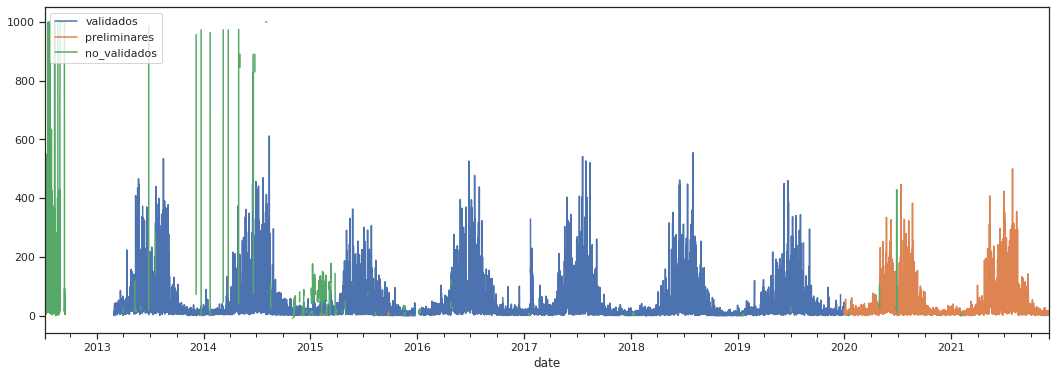

In [ ]:
fig, ax = plt.subplots(figsize=(18,6)) ## ahora comenzamos hacer las visualizaciones tomando los datos y gráficas de los con respecto al tiempo
df.plot(x="date", ax=ax)
plt.legend(loc='upper left')

En la grafica se pueden ver muchos valores no validados entre finales de 2012 y el primer trimestre de 2015, donde estos valores son atipicos. Lo que puede perjudicar a la construcción del modelo. Para tratar estos datos se tomará la decisión de tomarlos como valores faltantes dentro de ese periodo de tiempo.

(372672.0, 396600.0)

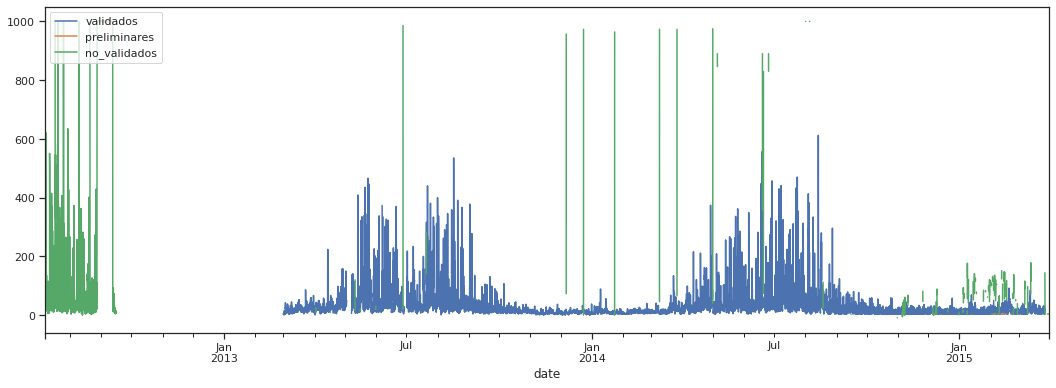

In [ ]:
fig, ax = plt.subplots(figsize=(18,6)) ## ahora comenzamos hacer las visualizaciones tomando los datos y gráficas de los con respecto al tiempo
df.plot(x="date", ax=ax)
plt.legend(loc='upper left')
plt.xlim('2012-07-07 00:00:00','2015-03-31 00:00:00')

Los valores faltantes que seran convertidos en NaN seran en total 1956 instancias

In [ ]:
df_no_val = df[(df['date'] >= "2012-07-07") & (df['date'] < "2015-03-31")]
count_no_validados = df_no_val.apply(lambda x: x['no_validados'] > 0, axis=1).sum()
print("PM25 no validados con valores menores o iguales a cero: {}".format(count_no_validados))

PM25 no validados con valores menores o iguales a cero: 1956


Convierte en NaN los valores no validados de concentración de PM25 que pertenecen al periodo de tiempo entre "2012-07-07" y "2015-03-31".





In [ ]:
df.loc[(df['date'] >= "2012-07-07") & (df['date'] < "2015-03-31"), 'no_validados'] = np.nan

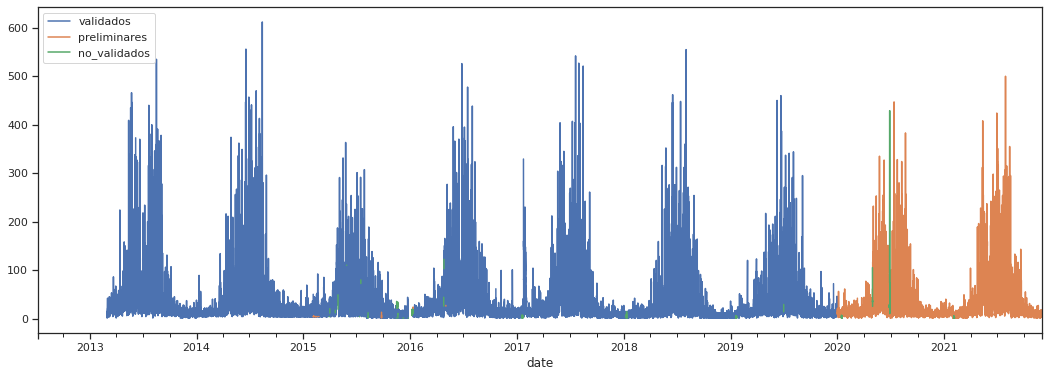

In [ ]:
fig, ax = plt.subplots(figsize=(18,6)) ## ahora comenzamos hacer las visualizaciones tomando los datos y gráficas de los con respecto al tiempo
df.plot(x="date", ax=ax)
plt.legend(loc='upper left')

Esta grafica tambien presenta valores atipicos en el verano de 2017, el cual puede estar relacionado a los incendios forestales ocurridos en la region del maule en ese año. Este supuesto puede ser validado con noticias de ese año [link](https://resumen.cl/articulos/zona-catastrofe-regiones-ohiggins-ymaule-incendios-forestales), donde expresan los situcacion de los incendios en las regiones afectadas.

In [ ]:
# Reemplaza todos los valores faltantes o NaN por un 0
df=df.fillna(0)

# Dado que la concentracion puede estar en tres estados posibles. Por lo que se 
# unen las columnas no validados, validados y preliminares.
df = df.assign(PM25 = lambda x: x.validados + x.preliminares + x.no_validados )
# Elimina los columnas que no se utilizaran en el analisis.
df= df.drop(columns=['validados', 'preliminares','no_validados'])

In [ ]:
df.sample(15)

,date,PM25
28966,2015-10-26 23:00:00,14.3583
81690,2021-10-31 19:00:00,10.0000
10793,2013-09-29 18:00:00,9.0000
38425,2016-11-24 02:00:00,6.0770
72341,2020-10-07 06:00:00,9.0000
49513,2018-03-01 02:00:00,6.0000
18412,2014-08-13 05:00:00,11.0000
5633,2013-02-26 18:00:00,0.0000
67151,2020-03-05 00:00:00,21.0000
56847,2018-12-31 16:00:00,1.0000


# Valores faltantes
******

Como se puede ver existen 8188 instancias con valores faltantes que son representados con un 0. Esta representacion se puede hacer dado que en un analisis previo se verifico que no existieran valores en 0, por lo que se puede asumir que las concentraciones $PM_{2,5}$ no puede tener un valor 0.

In [ ]:
df.apply(lambda x: x['PM25'] <= 0, axis=1).sum()

7412

Con el estudio de los datos faltantes se verifico que en el año 2012 existen muchos datos que faltan, por lo que se toma la desición de partir desde 03 de marzo de 2013 para el analisis de la serie de tiempo. Se asume que perder ese año no afectará mucho al analisis, dado que igual seran 8 años de concentraciones de $PM_{2,5}$ que seran analizadas.

con este recorte de los datos, los datos faltantes se reducieron a 1725, lo que equivale al 2,2% de los datos.

In [ ]:
df = df[(df['date'] >= "2013-03-01") & (df['date'] < "2021-11-30")]
df.apply(lambda x: x['PM25'] <= 0, axis=1).sum()


1725

Todos los valores menores a cero los cambia por un 0, para tomarlo como un dato faltante. 

In [ ]:
df.loc[df['PM25'] < 0, 'PM25'] = 0

In [ ]:
df.describe()

,PM25
count,76704.000000
mean,25.552802
std,37.651237
min,0.000000
25%,8.000000
50%,14.000000
75%,27.000000
max,612.000000


## Imputar datos faltantes

Para elegir un metodo de imputación, se compararan varios metodos de imputacion de datos. La medida utilizada para comparar sera $R^2$. 


Los metodos seran el mean value, median value, rolling mean, rolling median, y varios metodos del metodo interpolate de panda. 

Este forma de elegir el metodo de imputacion, se base en parte de una conferencia llamada, ["HANDLING DATA GAPS IN TIME SERIES USING IMPUTATION"](https://conferences.oreilly.com/strata/strata-ny-2019/cdn.oreillystatic.com/en/assets/1/event/300/Handling%20data%20gaps%20in%20time%20series%20using%20imputation%20Presentation.pdf), y un articulo de [medium](https://drnesr.medium.com/filling-gaps-of-a-time-series-using-python-d4bfddd8c460). 

Se convierte los ceros al formato np.nan para un mejor analisis y tratado de los datos faltantes

In [ ]:
df_nan = df.replace(0, np.nan)

Para analizar los metodos se toma una pequeña muestra de 8 semanas. Esta muestra es pequeña porque fue dificil encontrar una muestra más grande que no le faltaran datos. 

Se seleccionara el 20% de los datos aproximadamente 269 instancias, para convertilos en nan que se utlizaran para validar el metodo.

In [ ]:
df_nan = df_nan[(df_nan['date'] >= "2015-06-01") & (df_nan['date'] < "2015-07-27")]
valores_nan = df_nan['PM25'].isna().sum()
valores_totales =  df_nan['PM25'].count()

print("cantidad de valores NaN: {}".format(valores_nan))
print("cantidad de datos: {}".format(valores_totales))

df_nan


cantidad de valores NaN: 0
cantidad de datos: 1344


,date,PM25
25415,2015-06-01 00:00:00,91.50550
25416,2015-06-01 01:00:00,41.01070
25417,2015-06-01 02:00:00,28.32670
25418,2015-06-01 03:00:00,27.79080
25419,2015-06-01 04:00:00,55.84580
...,...,...
26754,2015-07-26 19:00:00,36.17250
26755,2015-07-26 20:00:00,35.50580
26756,2015-07-26 21:00:00,23.90670
26757,2015-07-26 22:00:00,13.85640


In [ ]:
np.random.seed(11)

# Datos para validacion
val = df_nan.sample(269)
# Renomanbra la columna PM25 por val
val = val.rename(columns={'PM25':'val',})

# Datos de entramiento para los metodos de imputación
train = df_nan[~df_nan.date.isin(val.date)] # se obtienen todos los valores de df_nan que no tienen una coincidencia en val (datos de validacion)
# Renomanbra la columna PM25 por train
train = train.rename(columns={'PM25':'train',})

# Une los tres dataframe
df_nan = df_nan.merge(train, how='outer', on='date').merge(val, how='outer', on='date')

# Se selecciona la columna date como indece para el conjunto
df_nan= df_nan.set_index('date')

df_nan

,PM25,train,val
date,,,
2015-06-01 00:00:00,91.50550,91.50550,NaN
2015-06-01 01:00:00,41.01070,41.01070,NaN
2015-06-01 02:00:00,28.32670,NaN,28.3267
2015-06-01 03:00:00,27.79080,27.79080,NaN
2015-06-01 04:00:00,55.84580,55.84580,NaN
...,...,...,...
2015-07-26 19:00:00,36.17250,36.17250,NaN
2015-07-26 20:00:00,35.50580,35.50580,NaN
2015-07-26 21:00:00,23.90670,23.90670,NaN


Grafica donde las lineas punteadas negras representan a la concentracion de $PM_{2,5}$, las linea de color azul con puntos representa al conjunto antes creado como entranamiento. Las estrellas de color rojo representan a los datos faltantes, que viene dado por el conjunto antes creado de validación. 

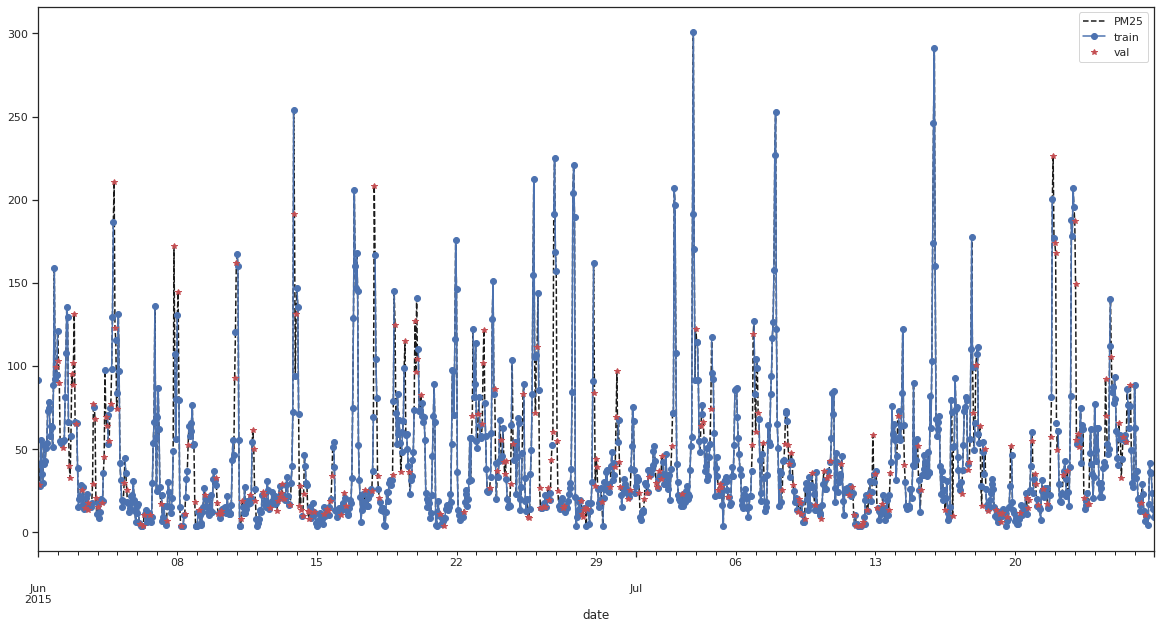

In [ ]:
df_nan.plot(style=['k--', 'bo-', 'r*'], figsize=(20, 10));


zoom del grafico para una mejor vizualización

(398136.0, 398208.0)

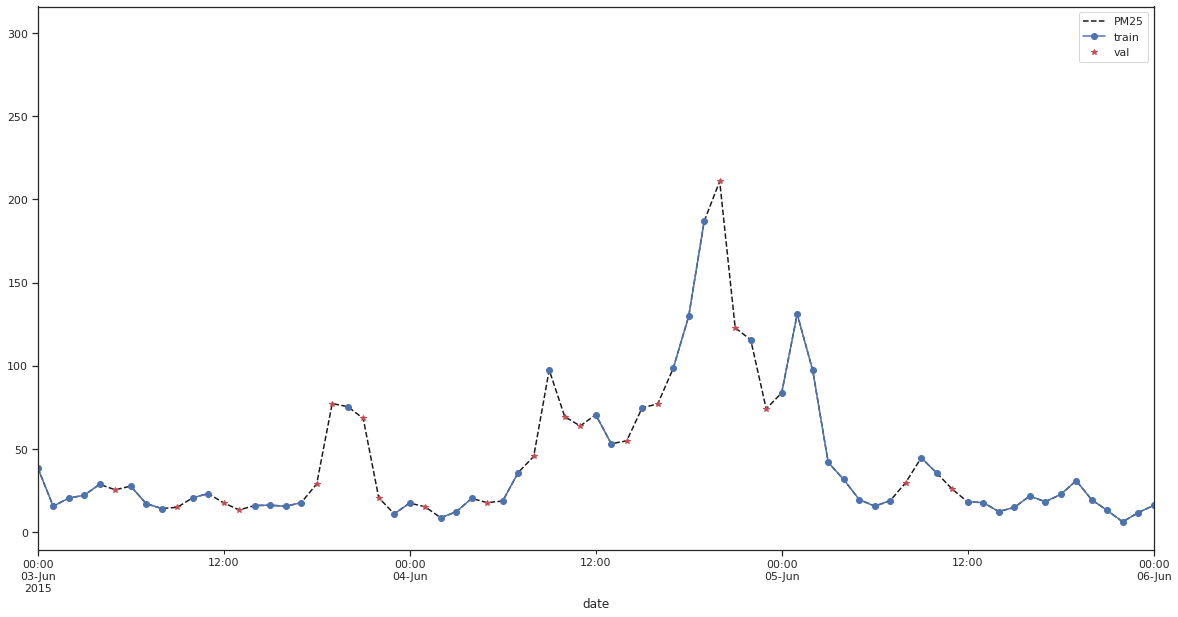

In [ ]:
df_nan.plot(style=['k--', 'bo-', 'r*'], figsize=(20, 10));
plt.xlim('2015-06-03 00:00:00','2015-06-06 00:00:00')

## Metodos de imputación

In [ ]:
# imputación utilizando el promedio
df_nan = df_nan.assign(FillMean=df_nan.train.fillna(df_nan.train.mean()))
# imputación utilizando la media
df_nan = df_nan.assign(FillMedian=df_nan.train.fillna(df_nan.train.median()))
#  imputación utilizando el promedio movil, de 24 horas.
df_nan = df_nan.assign(RollingMean=df_nan.train.fillna(df_nan.train.rolling(24,min_periods=1,).mean()))
# imputación utilizando la media movil, de 24 horas.
df_nan = df_nan.assign(RollingMedian=df_nan.train.fillna(df_nan.train.rolling(24,min_periods=1,).median()))

Para estudiar más a detalle los metodos de Interpolate [aqui](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.interpolate.html).

In [ ]:
# imputación utilizando un método de interpolación lineal.
df_nan = df_nan.assign(InterpolateLinear=df_nan.train.interpolate(method='linear'))
# imputación utilizando un método de interpolación de tiempo.
df_nan = df_nan.assign(InterpolateTime=df_nan.train.interpolate(method='time'))
# imputación utilizando un método de interpolación cuadratica.
df_nan = df_nan.assign(InterpolateQuadratic=df_nan.train.interpolate(method='quadratic'))
# imputación utilizando un método de interpolación cubica.
df_nan = df_nan.assign(InterpolateCubic=df_nan.train.interpolate(method='cubic'))
# imputación utilizando un método de interpolación llamado akima.
df_nan = df_nan.assign(InterpolateAkima=df_nan.train.interpolate(method='akima'))

In [ ]:
df_nan.sample(8)

,PM25,train,val,FillMean,FillMedian,RollingMean,RollingMedian,InterpolateLinear,InterpolateTime,InterpolateQuadratic,InterpolateCubic,InterpolateAkima
date,,,,,,,,,,,,
2015-06-27 02:00:00,24.63750,NaN,24.6375,42.868431,28.37000,73.485093,22.93710,63.14680,63.14680,53.444688,58.995056,49.541017
2015-06-19 00:00:00,53.07170,53.07170,NaN,53.071700,53.07170,53.071700,53.07170,53.07170,53.07170,53.071700,53.071700,53.071700
2015-06-29 01:00:00,39.04670,NaN,39.0467,42.868431,28.37000,30.880059,16.25670,53.23064,53.23064,54.015685,61.237862,51.793392
2015-06-06 02:00:00,5.55141,5.55141,NaN,5.551410,5.55141,5.551410,5.55141,5.55141,5.55141,5.551410,5.551410,5.551410
2015-06-07 16:00:00,11.42890,11.42890,NaN,11.428900,11.42890,11.428900,11.42890,11.42890,11.42890,11.428900,11.428900,11.428900
2015-07-15 04:00:00,31.36920,31.36920,NaN,31.369200,31.36920,31.369200,31.36920,31.36920,31.36920,31.369200,31.369200,31.369200
2015-06-07 18:00:00,20.80830,20.80830,NaN,20.808300,20.80830,20.808300,20.80830,20.80830,20.80830,20.808300,20.808300,20.808300
2015-06-08 12:00:00,36.96830,36.96830,NaN,36.968300,36.96830,36.968300,36.96830,36.96830,36.96830,36.968300,36.968300,36.968300


In [ ]:
# Calcula el r2_score, MSE y MAE de cada metodo de imputación
resultados = [(metodo, r2_score(df_nan.PM25, df_nan[metodo]), 
               mean_squared_error(df_nan.PM25, df_nan[metodo]), 
               mean_absolute_error(df_nan.PM25, df_nan[metodo])) for metodo in list(df_nan)[3:]]

# Crea un dataframe para guardar los resultados de las metricas de cada metodo
resultados_df = pd.DataFrame(np.array(resultados), columns=['Metodo', 'R_squared', 'MSE', 'MAE'])
# Ordenan de mayor a menor los resultados del R_squared
resultados_df.sort_values(by='R_squared', ascending=False)


,Metodo,R_squared,MSE,MAE
4,InterpolateLinear,0.9574013109677778,73.60927473188246,2.3848699925595236
5,InterpolateTime,0.9574013109677778,73.60927473188246,2.3848699925595236
8,InterpolateAkima,0.954575174014962,78.49275579939595,2.3597757806205792
6,InterpolateQuadratic,0.950278464537718,85.91734269488204,2.4008498714759683
7,InterpolateCubic,0.9494087180899214,87.42023883270724,2.450367670464287
0,FillMean,0.8044819721669787,337.8493693763782,5.969918238205978
2,RollingMean,0.8019280692371221,342.2624381039199,5.784935849981097
3,RollingMedian,0.7919441655238565,359.5143284325292,5.222540394345238
1,FillMedian,0.7757089382668111,387.56832095315457,5.51830806547619


In [ ]:
df_metodos_val = df_nan.reset_index() # Quita el index de date 
df_metodos_val = df_metodos_val[df_metodos_val.date.isin(val.date)] # se obtienen todos los valores de df_nan que no tienen una coincidencia en val (datos de validacion)
df_metodos_val = df_metodos_val.set_index('date') # selecciona a la columna date como indice

# Calcula el r2_score, MSE y MAE de cada metodo de imputación
resultados2 = [(metodo, r2_score(df_metodos_val.PM25, df_metodos_val[metodo]),
                mean_squared_error(df_metodos_val.PM25, df_metodos_val[metodo]),
                mean_absolute_error(df_metodos_val.PM25, df_metodos_val[metodo]) ) for metodo in list(df_metodos_val)[3:]]

# Crea un dataframe para guardar los resultados de las metricas de cada metodo
resultados_df2 = pd.DataFrame(np.array(resultados2), columns=['Metodo', 'R_squared', 'MSE', 'MAE'])
# Ordenan de mayor a menor los resultados del R_squared
resultados_df2.sort_values(by='R_squared', ascending=False)

,Metodo,R_squared,MSE,MAE
4,InterpolateLinear,0.7818996811325567,367.7727332328998,11.915484275092936
5,InterpolateTime,0.7818996811325567,367.7727332328998,11.915484275092936
8,InterpolateAkima,0.7674301895924303,392.17198436575524,11.790106502431444
6,InterpolateQuadratic,0.7454315382640104,429.2673181484069,11.995324264920823
7,InterpolateCubic,0.7409785379039572,436.7762118630428,12.242729178825286
1,FillMedian,-0.1483440733615946,1936.4008303384378,27.571026171003716
3,RollingMedian,-0.065221603583977,1796.235157670332,26.09328732342007
2,RollingMean,-0.014105181157033408,1710.0398394485812,28.903173912173212
0,FillMean,-0.00102949605937952,1687.9909012708265,29.827398186426894


El metodo de InterpolateLinear fue el que obtuvo el mejor R cuadrado se ajusta con un 95% de certeza al modelo y con un MSE de 73.6. Con los resultados obtenidos de esta pequeña muestra podemos decidir utilizar este metodo para rellenar los datos NaN del conjunto completo.

En la siguiente grafica se puede ver como el modelo de interpolacion lineal se ajusta a los datos. Donde es representado con una linea roja y una cruz, los valores que predijo para los datos faltantes.

(398136.0, 398208.0)

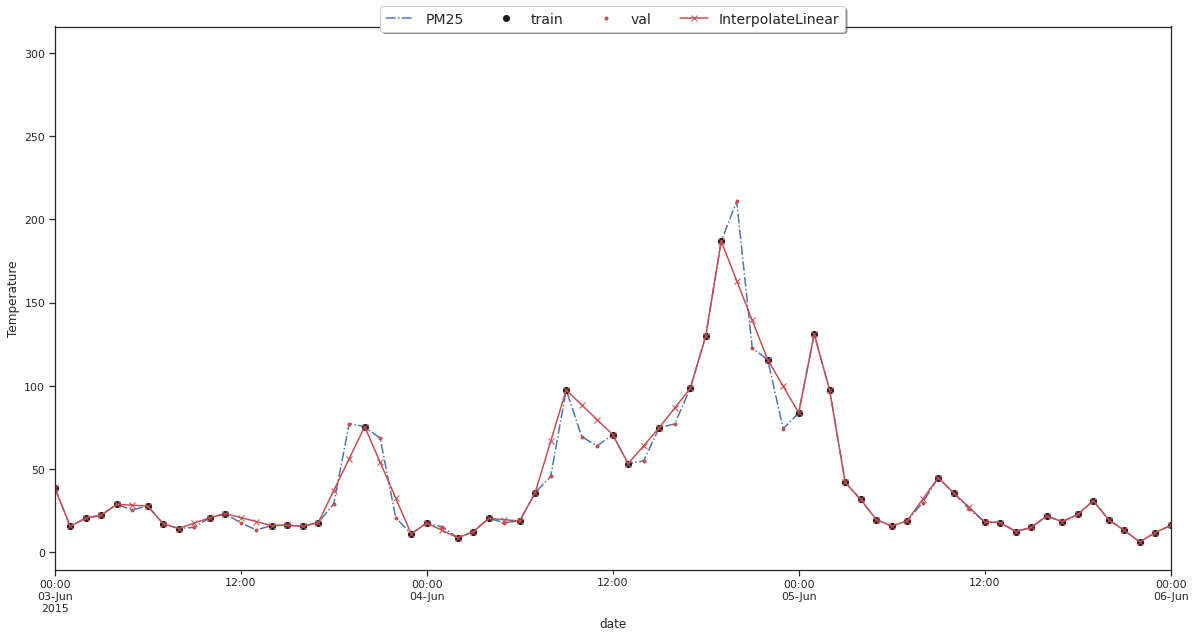

In [ ]:
final_df= df_nan[['PM25', 'train', 'val', 'InterpolateLinear', ]]
final_df.plot(style=['b-.', 'ko', 'r.', 'rx-', 'gx-'], figsize=(20,10));
plt.ylabel('Temperature');
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          fancybox=True, shadow=True, ncol=5, prop={'size': 14} );
plt.xlim('2015-06-03 00:00:00','2015-06-06 00:00:00')

## Imputación de datos

Todos los valores NaN seran rellenados con el metodo de Interpolacion lineal.

In [ ]:
# Reemplaza los 0 por np.nan
data = df.replace(0, np.nan) 
# Selecciona a la columna date como indice
data = data.set_index('date')

# cuenta la cantidad de NaN en la columna PM25
valores_nan = data['PM25'].isna().sum()
# Cuenta cuantos valores tiene la columna PM25 que no sean NaN
valores_totales =  data['PM25'].count()

print("cantidad de valores NaN: {}".format(valores_nan))
print("cantidad de datos: {}".format(valores_totales))

cantidad de valores NaN: 1725
cantidad de datos: 74979


In [ ]:
# imputación utilizando un método de interpolación lineal.
data = data.assign(PM25=data.PM25.interpolate(method='linear'))

In [ ]:
valores_nan = data['PM25'].isna().sum()
valores_totales =  data['PM25'].count()

print("cantidad de valores NaN: {}".format(valores_nan))
print("cantidad de datos: {}".format(valores_totales))

cantidad de valores NaN: 0
cantidad de datos: 76704


In [ ]:
data.describe()

,PM25
count,76704.000000
mean,25.962120
std,37.607077
min,0.100000
25%,8.000000
50%,14.000000
75%,28.000000
max,612.000000


# Visualizacion de serie de tiempo
******

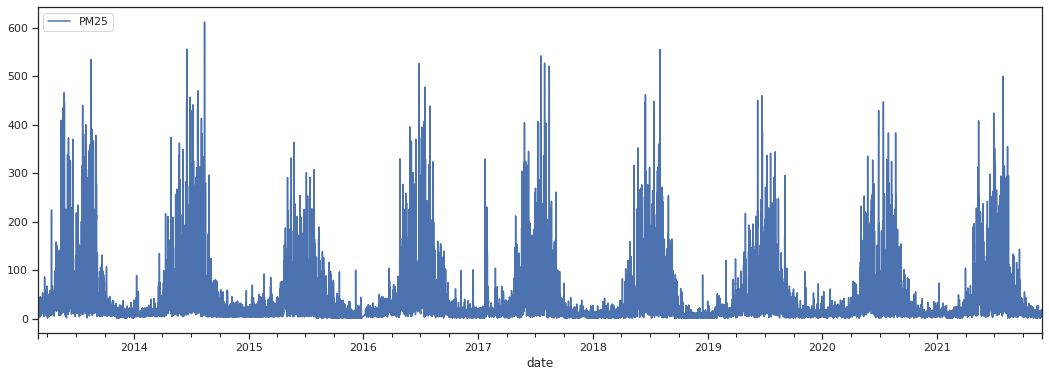

In [ ]:
fig, ax = plt.subplots(figsize=(18,6)) ## ahora comenzamos hacer las visualizaciones tomando los datos y gráficas de los con respecto al tiempo
data.plot( ax=ax)
plt.legend(loc='upper left')

#plt.savefig('images/intro-visualization.png'); ## recuerda crear la carpeta 'images'

#Vemos claramente ver el factor estacional, pero también se percibe el ciclo, que ocurre a más largo plazo
## bien se ve una tendencia al alza

El grafico muestra el promedio diario de concentraciones de PM25

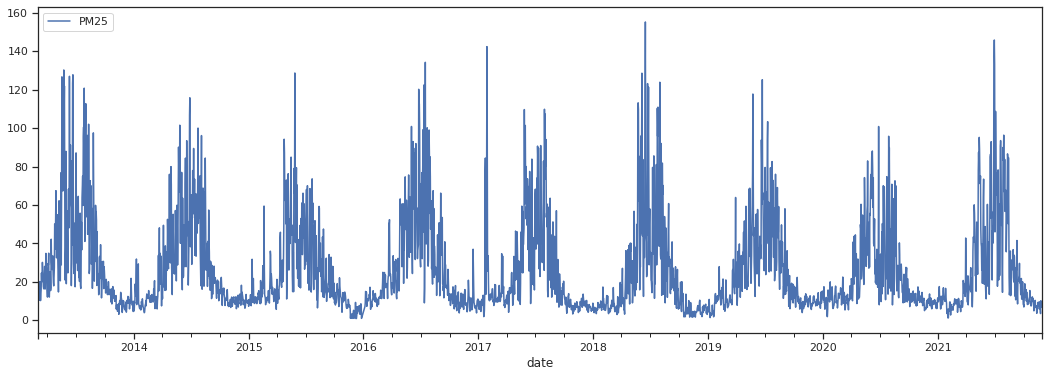

In [ ]:
# Promedio diario de PM25.
df_daily_average = data.resample('D').mean()

fig, ax = plt.subplots(figsize=(18,6)) ## ahora comenzamos hacer las visualizaciones tomando los datos y gráficas de los con respecto al tiempo
df_daily_average.plot( ax=ax)
plt.legend(loc='upper left')

# Modelos
******

Para probar los modelos Propjet de facebook y la red neuronal LSTM, se dividiran los datos en entrenamiento y validación. Donde el conjunto de entrenamiento contemplara los datos desde el 2013 al 2020. Por los que el año 2021 se tomaran como datos de validación. 

Este desición se toma por que los datos de entramiento son suficientes para predicir con un alto indice de precision las concentraciones de PM25 del año 2021. 

Tambien se cree que es suficiente predicir solo un año para mostrar la capacidad de predición de los modelos, porque en un año contemplamos la estacionalidad donde aumentan las concentraciones, y los demas meses donde se encuentran mas estables. 

In [ ]:
train = data[: '2020-12-31'] # dataframe de entramiento
test = data['2021-01-01':] # Dataframe de validacion
(test.index[0])


Timestamp('2021-01-01 00:00:00')

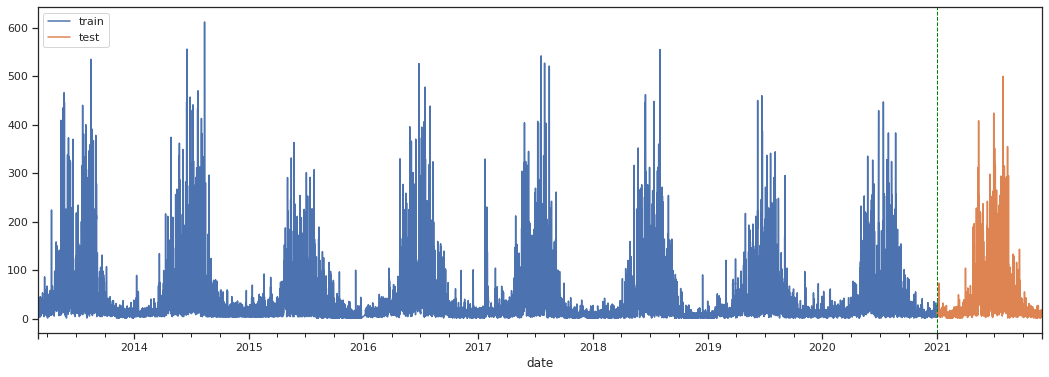

In [ ]:
fig, ax = plt.subplots(figsize=(18,6))
train.plot(y='PM25',ax=ax, label="train")
test.plot(y='PM25', ax=ax, label="test")

plt.axvline(pd.to_datetime(str(test.index[0])), c='green', ls='--', lw=1)
plt.legend(loc='upper left')

## Prophet

In [ ]:
from fbprophet import Prophet

In [ ]:
df_prophet_train = train.reset_index()
df_prophet_train.columns = ["ds", "y"]

model = Prophet(yearly_seasonality=True)

In [ ]:
model.fit(df_prophet_train)

In [ ]:
df_prophet_test = test.reset_index()
df_prophet_test.columns = ["ds", "y"]

forecast = model.predict(df_prophet_test[['ds']])
#forecast_ci = forecast[['ds', 'yhat_lower', 'yhat_upper']].set_index('ds')

yhat_test = forecast.yhat.values
y_test = df_prophet_test.y.values

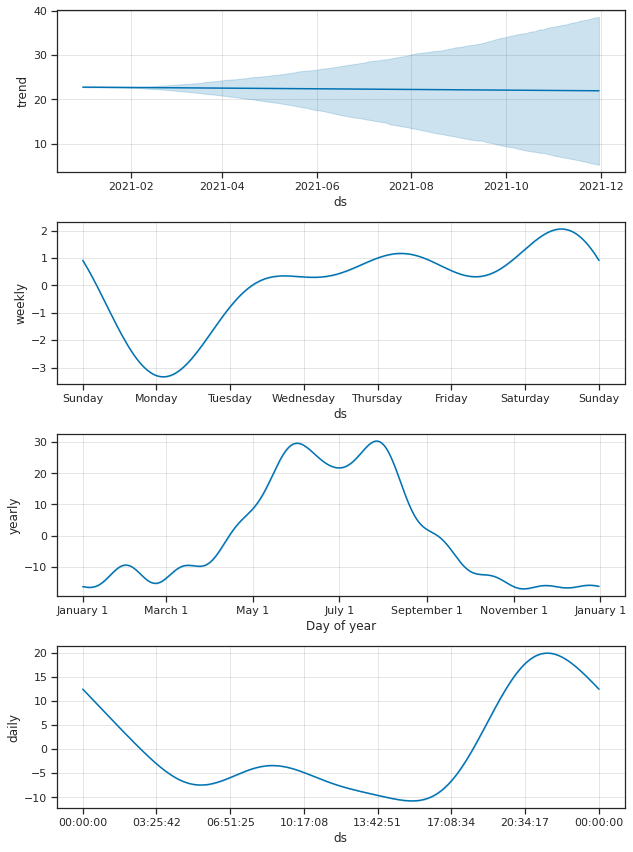

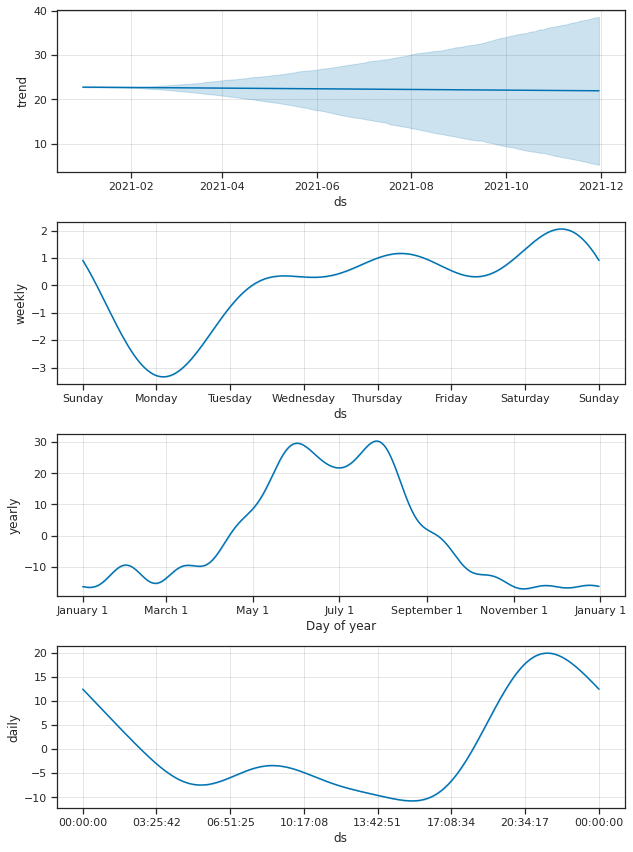

In [ ]:
model.plot_components(forecast)

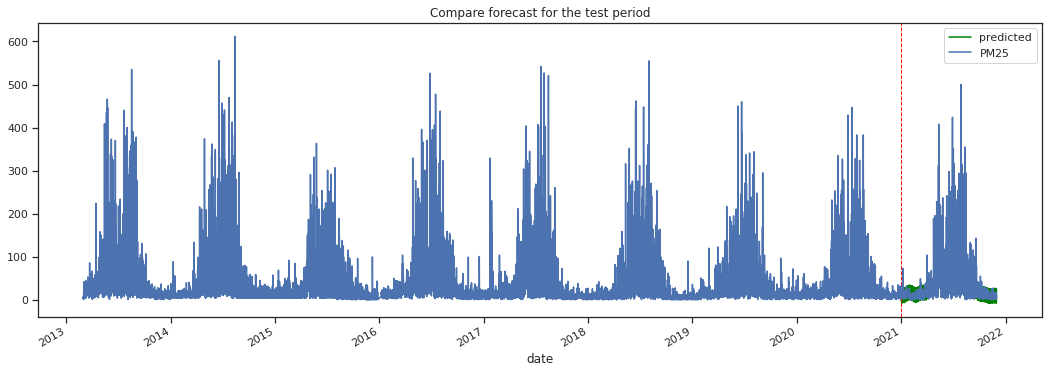

In [ ]:
fig, ax = plt.subplots(figsize=(18,6))
ax.plot(pd.to_datetime(df_prophet_test.ds.values), yhat_test,
        color="green", label="predicted")

plt.axvline(pd.to_datetime(str(df_prophet_test.ds.values[0])), c='red', ls='--', lw=1)
data.plot(ax=ax, label="observed")

plt.legend(loc='best')
plt.title('Compare forecast for the test period')

#plt.savefig('images/prophet-forecast-testrange.png')
plt.show();

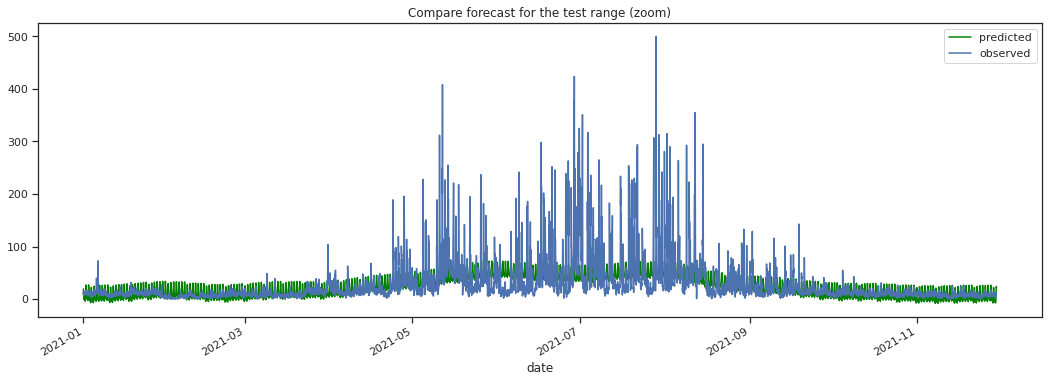

In [ ]:
fig, ax = plt.subplots(figsize=(18,6))
ax.plot(pd.to_datetime(df_prophet_test.ds.values), yhat_test,
        color="green", label="predicted")

data['2021-01-01':].plot( y='PM25',ax=ax, label="observed")
plt.legend(loc='best')
plt.title('Compare forecast for the test range (zoom)')


#plt.savefig('images/prophet-forecast-testrange-zoom.png')
plt.show();

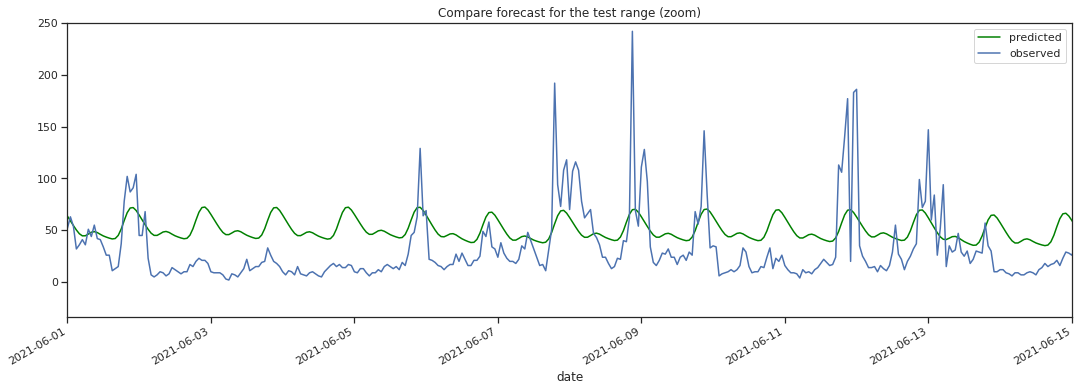

In [ ]:
fig, ax = plt.subplots(figsize=(18,6))
ax.plot(pd.to_datetime(df_prophet_test.ds.values), yhat_test,
        color="green", label="predicted")

data['2021-01-01':].plot( y='PM25',ax=ax, label="observed")
plt.legend(loc='best')
plt.title('Compare forecast for the test range (zoom)')

plt.xlim('2021-06-01 00:00:00','2021-06-15 00:00:00')
plt.ylim(top=250)
#plt.savefig('images/prophet-forecast-testrange-zoom.png')
plt.show();

In [ ]:
mae = mean_absolute_error(y_test, yhat_test)
mse = mean_squared_error(y_test, yhat_test)
r2 = r2_score(y_test, yhat_test)
mape = mean_absolute_percentage_error(y_test, yhat_test )

print("MAE (test): {:0.0f}".format(mae))
print("MSE (test): {:0.0f}".format(mse))
print("R2  (test): {:0.3f}".format(r2))
print("MAPE   (test): {:0.6f}".format(mape))

MAE (test): 18
MSE (test): 1093
R2  (test): 0.303
MAPE   (test): 1.198235


## LSTM

In [ ]:
def ts_train_test_normalize(all_data, time_steps, for_periods, name_target, start_date_train=None, end_date_train=None, start_date_test=None, end_date_test=None):
    '''
    input: 
      all_data: dataframe 
      time_steps: tamaño de la ventana para obtener una predicción
      for_periods: cantidad de datos a predecir 
      start_date_train: fecha de inicio de los datos de entramiento
      end_date_train: fecha de final de los datos de entramiento
      start_date_test: fecha de inicio de los datos de prueba
      end_date_test: fecha de final de los datos de prueba
    output:
      X_train, y_train: data de [start_date_train - end_date_train]
      X_test:  data de [start_date_test - end_date_test]
      sc:      instancia del objeto MinMaxScaler (Escala los datos de entrenamiento)
    '''



    start_date_train =  start_date_train if start_date_train else all_data.index[0]
    end_date_test =  end_date_test if end_date_test else all_data.index[len(all_data)-1]

    # crear un conjunto de entrenamiento y prueba
    ts_train = all_data[start_date_train : end_date_train].iloc[:,0:1].values
    ts_test  = all_data[start_date_test : end_date_test].iloc[:,0:1].values
    ts_train_len = len(ts_train)
    ts_test_len = len(ts_test)

    # Escalar los datos en el rango (0,1)
    sc = MinMaxScaler(feature_range=(0,1))
    ts_train_scaled = sc.fit_transform(ts_train)

    # Crear datos de entrenamiento de s muestras y t pasos de tiempo
    X_train = []
    y_train = []
    for i in range(time_steps,ts_train_len-1): 
        # Añade la ventana de t pasos de tiempo para el conjunto de entranamiento x
        X_train.append(ts_train_scaled[i-time_steps:i,0])
        # Añade la ventana de t' pasos de tiempo para el conjunto de entranamiento y 
        y_train.append(ts_train_scaled[i:i+for_periods,0])
    # Convierte los datos de entramiento en arreglos de numpy
    X_train, y_train = np.array(X_train), np.array(y_train)

    # Reestructura X_train a 3D [samples, timesteps, features]
    X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

    # Escala los datos para el conjunto de datos de prueba 
    inputs = pd.concat((all_data[name_target][start_date_train : end_date_train], all_data[name_target][start_date_test : end_date_test]),axis=0).values
    inputs = inputs[len(inputs)-len(ts_test) - time_steps:]
    inputs = inputs.reshape(-1,1) # Convertir en array cada valor del array. Ex: [1,2,3] -> [[1],[2],[3]]
    inputs  = sc.transform(inputs) # Escala los datos en el rango (0,1)

    # Crea los datos de prueba X_test de s muestras y t pasos de tiempo
    X_test, y_test = [], []
    for i in range(time_steps,ts_test_len+time_steps-for_periods):
        # Añade la ventana de t pasos de tiempo para el conjunto de prueba X
        X_test.append(inputs[i-time_steps:i,0])
        # Añade la ventana de t' pasos de tiempo para el conjunto de prueba y
        y_test.append(inputs[i:i+for_periods,0])
    # Convierte los datos de prueba en arreglos de numpy
    X_test, y_test = np.array(X_test), np.array(y_test)

    # Reestructura X_test a 3D [samples, timesteps, features]
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

    return X_train, y_train , X_test, y_test, sc

X_train, y_train, X_test, y_test, sc = ts_train_test_normalize(data,24,1,name_target='PM25', end_date_train='2020', start_date_test='2021')

print("There are " + str(X_train.shape[0]) + " samples in the training data - "+ str(X_train.shape) + " Ytrain: "+ str(y_train.shape))
print("There are " + str(X_test.shape[0]) + " samples in the test data - "+ str(X_test.shape) + " Ytrain: "+ str(y_test.shape))

There are 68687 samples in the training data - (68687, 24, 1) Ytrain: (68687, 1)
There are 7991 samples in the test data - (7991, 24, 1) Ytrain: (7991, 1)


In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model_LSTM = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20),
    keras.layers.Dense(1)
])

model_LSTM.compile(loss="mse", optimizer="adam",  metrics=['accuracy'])
history = model_LSTM.fit(X_train, y_train, epochs=20,verbose=1)
                    #validation_data=(X_valid, Y_valid))
model_LSTM.summary()

Epoch 1/20
2147/2147 [==============================] - 49s 21ms/step - loss: 0.0015 - accuracy: 1.4559e-05
Epoch 2/20
2147/2147 [==============================] - 45s 21ms/step - loss: 0.0012 - accuracy: 1.4559e-05
Epoch 3/20
2147/2147 [==============================] - 45s 21ms/step - loss: 0.0011 - accuracy: 1.4559e-05
Epoch 4/20
2147/2147 [==============================] - 45s 21ms/step - loss: 0.0011 - accuracy: 1.4559e-05
Epoch 5/20
2147/2147 [==============================] - 45s 21ms/step - loss: 0.0011 - accuracy: 1.4559e-05
Epoch 6/20
2147/2147 [==============================] - 46s 22ms/step - loss: 0.0011 - accuracy: 1.4559e-05
Epoch 7/20
2147/2147 [==============================] - 46s 21ms/step - loss: 0.0011 - accuracy: 1.4559e-05
Epoch 8/20
2147/2147 [==============================] - 46s 21ms/step - loss: 0.0011 - accuracy: 1.4559e-05
Epoch 9/20
2147/2147 [==============================] - 46s 21ms/step - loss: 0.0011 - accuracy: 1.4559e-05
Epoch 10/20
2147/2147 [=====

In [ ]:
# Finalizing predictions
LSTM_pred = model_LSTM.predict(X_test)
#from sklearn.preprocessing import MinMaxScaler
LSTM_pred = sc.inverse_transform(LSTM_pred)


testY_inverse = sc.inverse_transform(y_test)

mae = mean_absolute_error(testY_inverse, LSTM_pred)
mse = mean_squared_error(testY_inverse, LSTM_pred)
r2 = r2_score(testY_inverse, LSTM_pred)
mape = mean_absolute_percentage_error(testY_inverse, LSTM_pred)

print("MAE (test): {:0.0f}".format(mae))
print("MSE (test): {:0.0f}".format(mse))
print("R2  (test): {:0.3f}".format(r2))
print("MAPE   (test): {:0.6f}".format(mape))

MAE (test): 9
MSE (test): 410
R2  (test): 0.738
MAPE   (test): 0.344531


## LSTM 2

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model_LSTM_2 = keras.models.Sequential([
    keras.layers.LSTM(100, return_sequences=True, input_shape=[None, 1]),
    keras.layers.Dropout(0.2),
    keras.layers.LSTM(70),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(1)
])


model_LSTM_2.compile(loss="mse", optimizer="adam",  metrics=['accuracy'])
history = model_LSTM_2.fit(X_train, y_train, epochs=20, batch_size=70,verbose=1)
                    #validation_data=(X_valid, Y_valid))
model_LSTM_2.summary()

Epoch 1/20
982/982 [==============================] - 57s 55ms/step - loss: 0.0015 - accuracy: 1.4559e-05
Epoch 2/20
982/982 [==============================] - 54s 55ms/step - loss: 0.0012 - accuracy: 1.4559e-05
Epoch 3/20
982/982 [==============================] - 54s 55ms/step - loss: 0.0012 - accuracy: 1.4559e-05
Epoch 4/20
982/982 [==============================] - 54s 55ms/step - loss: 0.0012 - accuracy: 1.4559e-05
Epoch 5/20
982/982 [==============================] - 55s 56ms/step - loss: 0.0012 - accuracy: 1.4559e-05
Epoch 6/20
982/982 [==============================] - 55s 56ms/step - loss: 0.0012 - accuracy: 1.4559e-05
Epoch 7/20
982/982 [==============================] - 54s 55ms/step - loss: 0.0012 - accuracy: 1.4559e-05
Epoch 8/20
982/982 [==============================] - 54s 55ms/step - loss: 0.0012 - accuracy: 1.4559e-05
Epoch 9/20
982/982 [==============================] - 54s 55ms/step - loss: 0.0012 - accuracy: 1.4559e-05
Epoch 10/20
982/982 [=========================

In [ ]:
# Finalizing predictions
LSTM_pred_2 = model_LSTM_2.predict(X_test)
#from sklearn.preprocessing import MinMaxScaler
LSTM_pred_2 = sc.inverse_transform(LSTM_pred_2)


testY_inverse = sc.inverse_transform(y_test)

mae = mean_absolute_error(testY_inverse, LSTM_pred_2)
mse = mean_squared_error(testY_inverse, LSTM_pred_2)
r2 = r2_score(testY_inverse, LSTM_pred_2)
mape = mean_absolute_percentage_error(testY_inverse, LSTM_pred_2)

print("MAE (test): {:0.0f}".format(mae))
print("MSE (test): {:0.0f}".format(mse))
print("R2  (test): {:0.3f}".format(r2))
print("MAPE   (test): {:0.6f}".format(mape))

MAE (test): 8
MSE (test): 416
R2  (test): 0.735
MAPE   (test): 0.331709


In [85]:
def R_squared(y, y_pred):
    '''
    R_squared computes the coefficient of determination.
    It is a measure of how well the observed outcomes are replicated by the model.
    '''
    residual = tf.reduce_sum(tf.square(tf.subtract(y, y_pred)))
    total = tf.reduce_sum(tf.square(tf.subtract(y, tf.reduce_mean(y))))
    r2 = tf.subtract(1.0, tf.divide(residual, total))
    return r2

R_squared(testY_inverse, LSTM_pred_2)

<tf.Tensor: shape=(), dtype=float64, numpy=0.7347441251121773>